In [1]:
use_gpu = True
use_ramdon_split = True
use_dataparallel = True

In [27]:
import os
import sys
sys.path.insert(0, '..')

import time
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(42)


## load target data



In [18]:
label_df = pd.read_csv('load_data/Target-train.csv')

In [19]:
label_df = label_df.sort_values(by=['Description', 'Quote_Start_Date']).reset_index(drop=True)
label_df.to_csv('load_data/Target-train.csv')

In [20]:
([i[6:-34] for i in sorted(os.listdir('imgs/10p5-train'))[1:]] == label_df.Description).value_counts()

Description
True    29742
Name: count, dtype: int64

# Load image data

In [30]:
# Load the image
images_list = sorted(os.listdir('imgs/10p5-train'))[1:]
images = []
for i in tqdm(images_list):

        image_path = f'imgs/10p5-train/{i}'  # Replace with the path to your image
        image = Image.open(image_path)

        # Convert the image to a NumPy array
        image_array = np.array(image)
        images.append(image_array)

    
images = np.array(images)

100%|███████████████████████████████████| 29742/29742 [00:20<00:00, 1432.96it/s]


In [37]:
np.save('image_array-train.npy', images )

In [11]:
images = np.load('load_data/images_array-train.npy')

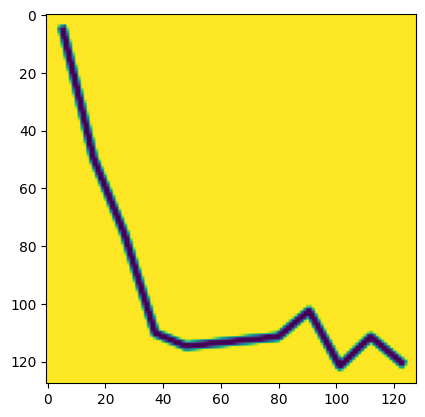

In [33]:
plt.imshow(images[2])

In [32]:
label_df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,Label,Return,Description,Quote_Start_Date
0,0,0,20357,1,0.784314,2016-01-29-108.0-AAPL,2016-01-04
1,1,1,7516,1,0.517672,2016-01-29-95.0-AAPL,2016-01-04
2,2,2,1406,1,0.741935,2016-02-05-106.0-AAPL,2016-01-04
3,3,3,29558,1,inf,2016-02-05-131.0-AAPL,2016-01-04
4,4,4,246,1,inf,2016-02-05-132.0-AAPL,2016-01-04
...,...,...,...,...,...,...,...
29737,29737,29737,11234,0,-0.087437,2025-01-17-490.0-TSLA,2022-09-13
29738,29738,29738,26904,1,0.951220,2025-01-17-565.0-SPY,2022-09-12
29739,29739,29739,26292,0,-0.030075,2025-01-17-60.0-NVDA,2022-09-12
29740,29740,29740,21840,0,-0.080024,2025-01-17-75.0-AAPL,2022-09-12


## build dataset

In [32]:
class MyDataset(Dataset):
    
    def __init__(self, img, label):
        self.img = torch.Tensor(img.copy())
        self.label = torch.Tensor(label)
        self.len = len(img)
  
    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.img[idx], self.label[idx]

Split method (not random split is recommended)

In [36]:
from sklearn.model_selection import train_test_split

# Use 70%/30% ratio for train/validation split
train_indices, val_indices = train_test_split(
    np.arange(images.shape[0]),
    test_size=0.3,
    random_state=42
)

# Create datasets based on the selected indices
train_dataset = MyDataset(images[train_indices], label_df['Label'].values[train_indices])
val_dataset = MyDataset(images[val_indices], label_df['Label'].values[val_indices])

# Create data loaders
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)

## models

In [38]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)
    elif isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)

In [146]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(5, 3), stride=(3, 1), dilation=(2, 1), padding=(12, 1)),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d((2, 1), stride=(2, 1)),
        )
        self.fc1 = nn.Sequential(
            nn.Dropout(p=0.5),
            # Adjust the input size based on the actual size after layer3
            nn.Linear(131072, 2),  # Adjusted input size
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
#         print("Input size:", x.size())
        x = x.reshape(-1, 1, 128, 128)
        x = self.layer1(x)
#         print("After layer1 size:", x.size())
        x = self.layer2(x)
#         print("After layer2 size:", x.size())
        x = self.layer3(x)
#         print("After layer3 size:", x.size())
        x = x.view(x.size(0), -1)  # Flatten before the linear layer
#         print("After flattening size:", x.size())
        x = self.fc1(x)
#         print("After fc1 size:", x.size(), x)
        x = self.softmax(x)
#         print("After soft size:", x.size(), x)
        return x

In [147]:
use_gpu = False
device = 'cpu'
export_onnx = True
net = Net().to(device)
net.apply(init_weights)

if export_onnx:
    import torch.onnx
    x = torch.randn([1, 1, 128, 128]).to(device)
    torch.onnx.export(net,               # model being run
                      x,                         # model input (or a tuple for multiple inputs)
                      "./cnn_baseline.onnx",   # where to save the model (can be a file or file-like object)
                      export_params=False,        # store the trained parameter weights inside the model file
                      opset_version=10,          # the ONNX version to export the model to
                      do_constant_folding=False,  # whether to execute constant folding for optimization
                      input_names=['input_images'],   # the model's input names
                      output_names=['output_prob'], # the model's output names
                      dynamic_axes={'input_images': {0: 'batch_size'},    # variable length axes
                                     'output_prob': {0: 'batch_size'}})

================ Diagnostic Run torch.onnx.export version 2.0.1 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



### Profiling

In [148]:
count = 0
for name, parameters in net.named_parameters():
    print(name, ':', parameters.size())
    count += parameters.numel()
print('total_parameters : {}'.format(count))

layer1.0.weight : torch.Size([64, 1, 5, 3])
layer1.0.bias : torch.Size([64])
layer1.1.weight : torch.Size([64])
layer1.1.bias : torch.Size([64])
layer2.0.weight : torch.Size([128, 64, 5, 3])
layer2.0.bias : torch.Size([128])
layer2.1.weight : torch.Size([128])
layer2.1.bias : torch.Size([128])
layer3.0.weight : torch.Size([256, 128, 5, 3])
layer3.0.bias : torch.Size([256])
layer3.1.weight : torch.Size([256])
layer3.1.bias : torch.Size([256])
fc1.1.weight : torch.Size([2, 131072])
fc1.1.bias : torch.Size([2])
total_parameters : 878850


In [149]:
from torch.profiler import profile, record_function, ProfilerActivity

inputs = next(iter(train_dataloader))[0].to(device)

with profile(activities=[
        ProfilerActivity.CPU, ProfilerActivity.CUDA], record_shapes=True) as prof:
    with record_function("model_inference"):
        net(inputs)

prof.export_chrome_trace("../trace.json")
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                             Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls  
---------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  model_inference         5.68%       1.829ms       100.00%      32.217ms      32.217ms             1  
                    aten::reshape         0.05%      15.000us         0.09%      28.000us      28.000us             1  
             aten::_reshape_alias         0.04%      13.000us         0.04%      13.000us      13.000us             1  
                     aten::conv2d         0.06%      18.000us        71.88%      23.158ms       7.719ms             3  
                aten::convolution         0.23%      75.000us        71.83%      23.140ms       7.713ms             3  
               aten::_convolution       

STAGE:2023-12-20 17:24:54 36166:863919 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2023-12-20 17:24:54 36166:863919 ActivityProfilerController.cpp:317] Completed Stage: Collection
STAGE:2023-12-20 17:24:54 36166:863919 ActivityProfilerController.cpp:321] Completed Stage: Post Processing


## train

In [150]:

def train_loop(dataloader, net, loss_fn, optimizer):
    
    running_loss = 0.0
    current = 0
    net.train()
    
    with tqdm(dataloader) as t:
        for batch, (X, y) in enumerate(t):
            X = X.to(device)
            y = y.to(device)
            y_pred = net(X)

            if y == 1:
                y = torch.tensor([0, 1]).unsqueeze(0)
                y = y.to(torch.float32)
            else:
                y = torch.tensor([1, 0]).unsqueeze(0)
                y = y.to(torch.float32)
                    
            y = y.to(device)        
                    
            loss = loss_fn(y_pred, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss = (len(X) * loss.item() + running_loss * current) / (len(X) + current)
            current += len(X)
            t.set_postfix({'running_loss':running_loss})
    
    return running_loss


def val_loop(dataloader, net, loss_fn):

    running_loss = 0.0
    current = 0
    net.eval()
    
    with torch.no_grad():
        with tqdm(dataloader) as t:
            for batch, (X, y) in enumerate(t):
                X = X.to(device)
                y = y.to(device)
                y_pred = net(X)
                
                
                if y == 1:
                    y = torch.tensor([0, 1]).unsqueeze(0)
                    y = y.to(torch.float32)
                else:
                    y = torch.tensor([1, 0]).unsqueeze(0)
                    y = y.to(torch.float32)
                    
                y = y.to(device)

                loss = loss_fn(y_pred, y)

  
                running_loss += loss.item()
                running_loss = (len(X) * running_loss + loss.item() * current) / (len(X) + current)
                current += len(X)
            
    return running_loss
            

In [151]:
if use_gpu and use_dataparallel and 'DataParallel' not in str(type(net)):
    net = net.to(device)
    net = nn.DataParallel(net)

In [152]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-5)

start_epoch = 0
min_val_loss = 1e9
last_min_ind = -1
early_stopping_epoch = 5

from torch.utils.tensorboard import SummaryWriter
tb = SummaryWriter()

In [153]:
start_time = datetime.datetime.now().strftime('%Y%m%d_%H:%M:%S')
epochs = 100
for t in range(start_epoch, epochs):
    print(f"Epoch {t}\n-------------------------------")
    time.sleep(0.2)
    train_loss = train_loop(train_dataloader, net, loss_fn, optimizer)
    val_loss = val_loop(val_dataloader, net, loss_fn)
    tb.add_histogram("train_loss", train_loss, t)
    torch.save(net, './CNN'+os.sep+start_time+os.sep+'baseline_epoch_{}_train_{:5f}_val_{:5f}.pt'.format(t, train_loss, val_loss)) 
    if val_loss < min_val_loss:
        last_min_ind = t
        min_val_loss = val_loss
    elif t - last_min_ind >= early_stopping_epoch:
        break

print('Done!')
print('Best epoch: {}, val_loss: {}'.format(last_min_ind, min_val_loss))

Epoch 0
-------------------------------


  0%|▏                                                 | 89/20819 [00:06<24:32, 14.08it/s, running_loss=1.45]


KeyboardInterrupt: 

In [ ]:
y_pred